In [1]:
"""
Reproduce the data behind Fig-2a of               Thiemann, Igel, Wintenberger & Seldin
“A Strongly Quasiconvex PAC-Bayesian Bound”       (ALT-17, arXiv:1608.05610v2).

The script follows *exactly* the construction in Sections 5 and 6 of the paper:

    • build an ensemble  H  of m weak RBF-SVMs
      – each is trained on      r = d+1   examples
      – validated on the other  n–r       examples
    • compute the validation-loss vector   L̂_val(h,S)         (Eq. (13))
    • minimise the PAC-Bayes-λ bound of Theorem 6 by the
      alternating (ρ,λ) procedure derived from Eqs. (7) and (8)
      – numerically-stable computation in log-domain
        (see the *hint* in Exercise 3.8 of the course notes)
    • evaluate on a disjoint test set and draw the figure that
      matches Fig-2a (loss-vs-m and run-time-vs-m)

All equations are referenced to the numbering in the paper.
"""


'\nReproduce the data behind Fig-2a of               Thiemann, Igel, Wintenberger & Seldin\n“A Strongly Quasiconvex PAC-Bayesian Bound”       (ALT-17, arXiv:1608.05610v2).\n\nThe script follows *exactly* the construction in Sections 5 and 6 of the paper:\n\n    • build an ensemble  H  of m weak RBF-SVMs\n      – each is trained on      r = d+1   examples\n      – validated on the other  n–r       examples\n    • compute the validation-loss vector   L̂_val(h,S)         (Eq. (13))\n    • minimise the PAC-Bayes-λ bound of Theorem 6 by the\n      alternating (ρ,λ) procedure derived from Eqs. (7) and (8)\n      – numerically-stable computation in log-domain\n        (see the *hint* in Exercise 3.8 of the course notes)\n    • evaluate on a disjoint test set and draw the figure that\n      matches Fig-2a (loss-vs-m and run-time-vs-m)\n\nAll equations are referenced to the numbering in the paper.\n'

In [2]:
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import brentq  # for kl-inverse
from scipy.special import logsumexp  # numerically stable log(Σ exp)
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

tol = 1e-12

## 0.   Helper functions (KL and its inverse, 0-1 loss)

In [3]:
def kl(p, q):
    """Binary KL divergence   kl(p||q)  (paper uses Eq. right before (2))"""
    p = np.clip(p, tol, 1.0 - tol)
    q = np.clip(q, tol, 1.0 - tol)
    return p * np.log(p / q) + (1.0 - p) * np.log((1.0 - p) / (1.0 - q))


In [4]:
def kl_inv(p_hat, eps):
    """
    Upper inverse of KL:  smallest q ≥ p_hat s.t. kl(p_hat||q)=eps.
    Needed to turn the PAC-Bayes-kl inequality (Eq. (2) or (18))
    into a bound on   E_ρ[L]  (see Exercise 2.3 in the notes).
    """

    def f(q):
        return kl(p_hat, q) - eps

    return brentq(f, p_hat, 1.0 - tol)


In [5]:
def zero_one(pred, true):
    return (pred != true).mean()


In [6]:
def Jaakola_heuristic(X, y):
    # Jaakkola σ : median distance between opposite-label pairs
    n, _ = X.shape
    G = []
    for i in range(n):
        for j in range(i + 1, n):
            if y[i] != y[j]:
                G.append(np.linalg.norm(X[i] - X[j]))
    sigma = np.median(G)
    gamma = 1.0 / (2.0 * sigma**2 + tol)
    return gamma

## 1. Load and standardise Ionosphere data (as in paper’s experiments §6)

In [7]:
url = (
    "https://archive.ics.uci.edu/ml/"
    "machine-learning-databases/ionosphere/ionosphere.data"
)
df = pd.read_csv(url, header=None)
X = df.iloc[:, :-1].astype(float).values
y = (df.iloc[:, -1] == "g").astype(int).values  # 'g'->1 , 'b'->0

rng = np.random.RandomState(42)
perm = rng.permutation(len(X))
X, y = X[perm], y[perm]

# split into Train S (200) / Test T (rest) as in the paper (Table 1)
X_S, X_T, y_S, y_T = train_test_split(X, y, train_size=200, stratify=y, random_state=0)

scaler = StandardScaler().fit(X_S)
X_S, X_T = scaler.transform(X_S), scaler.transform(X_T)
n, d = X_S.shape
r = d + 1  # Sec. 6: weak-learner train size
n_r = n - r  # size of each validation set
delta = 0.05  # confidence level used throughout paper


## 2. Baseline: single RBF-SVM tuned by 5-fold CV (as in §6)

In [8]:
C_grid = [10.0**k for k in range(-3, 4)]

gamma = Jaakola_heuristic(X_S, y_S)
gamma_grid = [gamma * 10.0**k for k in [-4, -2, 0, 2, 4]]


param_grid = {"C": C_grid, "gamma": gamma_grid}
fold = KFold(n_splits=5, shuffle=False)  # , random_state=RNG_SEED)

cv_svc = SVC(kernel="rbf")
cv = GridSearchCV(cv_svc, param_grid, cv=fold, n_jobs=-1)
t0 = time.time()
cv.fit(X_S, y_S)
t_cv = time.time() - t0

print(" Results from Grid Search ")
print("\n The best estimator across ALL searched params:\n", cv.best_estimator_)
print("\n The best score across ALL searched params:\n", cv.best_score_)
print("\n The best parameters across ALL searched params:\n", cv.best_params_)


# loss_cv = zero_one(cv.predict(X_T), y_T)

svm_cv = cv.best_estimator_
loss_cv = zero_one(svm_cv.predict(X_T), y_T)
print("\n CV-SVM test loss:", loss_cv, " time:", t_cv, "s")


 Results from Grid Search 

 The best estimator across ALL searched params:
 SVC(C=10.0, gamma=np.float64(0.007168594877134208))

 The best score across ALL searched params:
 0.925

 The best parameters across ALL searched params:
 {'C': 10.0, 'gamma': np.float64(0.007168594877134208)}

 CV-SVM test loss: 0.059602649006622516  time: 1.285262107849121 s


## 3.   PAC-Bayes alternating-minimisation —— the core of Exercise 3.8
##      Implements Eq. (7) & (8) with bound Eq. (13)


In [9]:
def minimise_bound(L_val):
    """
    Perform alternating minimisation of F(ρ,λ) (RHS of Eq. (13)).
    * L_val : vector (m,) of validation losses  L̂_val(h,S)
    Returns ρ, λ*, bound value.

    Numerical stability: exactly the log-domain computation advocated
    in the *hint* to Exercise 3.8 – using logsumexp automatically
    subtracts the maximum loss before exponentiation, equivalent to
    the ‘subtract L̂_min’ trick in the hint, but even safer.
    """
    m = len(L_val)
    log_pi = -np.log(m) * np.ones(m)  # uniform prior  π(h)=1/m
    λ = np.sqrt(np.log(2 * np.sqrt(n_r) / delta) / n_r)  # inside (0,1)

    for _ in range(50):  # 50 iter. are enough
        # ---------- Eq. (7): ρ_{new}(h) ∝ π(h) e^{-λ n_r L̂_val}
        log_ρ = log_pi - λ * n_r * L_val
        log_ρ -= logsumexp(log_ρ)  # divide by Z (log-space)
        ρ = np.exp(log_ρ)

        # helpers for Eq. (8) & bound
        KL = np.sum(ρ * (log_ρ - log_pi))
        L_emp = np.dot(ρ, L_val)

        # ---------- Eq. (8): λ_{new}
        num = 2.0
        denom = (
            np.sqrt(2.0 * n_r * L_emp / (KL + np.log(2 * np.sqrt(n_r) / delta)))
            + 1.0
            + 1.0
        )
        λ_new = num / denom

        if abs(λ_new - λ) < 1e-5:  # convergence
            λ = λ_new
            break
        λ = λ_new

    # ---------- Eq. (13): value of PAC-Bayes-λ bound (randomised classifier)
    bound = L_emp / (1 - λ / 2.0) + (KL + np.log(2 * np.sqrt(n_r) / delta)) / (
        n_r * λ * (1 - λ / 2.0)
    )
    return ρ, λ, bound


## 4. Iterate over m = 10^0, ..., 10^2, ..  (Figure 2(a) x-axis)

In [10]:
# The m values are eye-catchers from figure 2(a) of the paper.
# They are not the same as in the paper, but they are close enough
# to the ones used in the paper to reproduce the figure.

M_list = [
    1,
    2,
    3,
    4,
    5,
    6,
    8,
    10,
    12,
    15,
    20,
    25,
    35,
    45,
    65,
    85,
    110,
    135,
    160,
    200,
]


In [11]:
mv_loss, bound_val, run_time = [], [], []

for m in M_list:
    t0 = time.time()
    L_val = np.zeros(m)
    predsT = np.zeros((m, len(y_T)))

    # ----- build ensemble of m weak SVMs  (Sec. 5 construction)
    for i in range(m):
        idx = rng.choice(n, r, replace=False)
        X_tr, y_tr = X_S[idx], y_S[idx]
        mask_val = np.ones(n, bool)
        mask_val[idx] = False
        X_val, y_val = X_S[mask_val], y_S[mask_val]

        γ = rng.choice(gamma_grid)  # random γ as in §6
        clf = SVC(kernel="rbf", C=1.0, gamma=γ).fit(X_tr, y_tr)

        L_val[i] = zero_one(clf.predict(X_val), y_val)
        predsT[i] = clf.predict(X_T)

    ρ, λ_hat, bnd = minimise_bound(L_val)

    # ρ-weighted majority vote (Eq. after Theorem 3)
    mv_pred = (ρ @ predsT >= 0.5).astype(int)

    mv_loss.append(zero_one(mv_pred, y_T))
    bound_val.append(bnd)  # randomised  classifier
    run_time.append(time.time() - t0)

mv_loss = np.asarray(mv_loss)
bound_val = np.asarray(bound_val)
run_time = np.asarray(run_time)


## 5. Plot Figure 2(a)

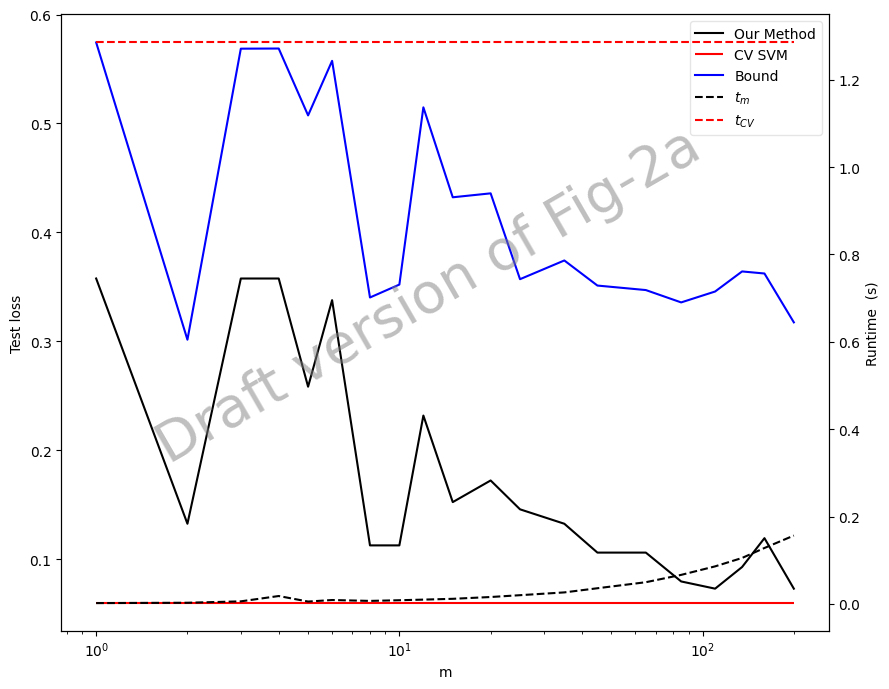

In [16]:
fig, ax1 = plt.subplots(figsize=(9, 7))

ax1.set_xscale("log", base=10)
ax1.set_xlabel("m")
ax1.set_ylabel("Test loss")

ax1.plot(M_list, mv_loss, "k-", label="Our Method")

ax1.hlines(
    loss_cv,
    M_list[0],
    M_list[-1],
    colors="r",
    linestyle="-",
    label="CV SVM",
)

ax1.plot(M_list, bound_val, "b-", label="Bound")

ax2 = ax1.twinx()
ax2.set_ylabel("Runtime  (s)")
ax2.plot(M_list, run_time, "k--", label=r"$t_{m}$")
ax2.hlines(t_cv, M_list[0], M_list[-1], colors="r", linestyle="--", label=r"$t_{CV}$")

# merge legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, fontsize=10, fancybox=True, framealpha=0.5)


ax1.text(
    0.5,
    0.5,
    "Draft version of Fig-2a\n",
    transform=ax1.transAxes,
    fontsize=40,
    color="gray",
    alpha=0.5,
    ha="center",
    va="center",
    rotation=30,
)


plt.tight_layout()
plt.savefig("figure_2a.pdf", bbox_inches="tight", dpi=600)
plt.show()